In [1]:
from utility_bfsolver import *
from utility_dfcounter import *

# 1. Optimize the pT threshold of Tau

In [2]:
def getTauIDError(a,ndata,nmcbg,nfake,tr):
    slv = BFSolver3D(a)
    BW = slv.solveQuadEqn(slv.setMeasuredX(nData=ndata, nMcbg=nmcbg+nfake))
    #print(BW)
    
    a1 = a.copy()    
    if tr == 'mu':
        a1[2,1,4] = a[2,1,4]*1.05
        a1[2,4,1] = a[2,4,1]*1.05
    else:
        a1[2,0,4] = a[2,0,4]*1.05
        a1[2,4,0] = a[2,4,0]*1.05

    slv1 = BFSolver3D(a1)
    BW1 = slv1.solveQuadEqn(slv1.setMeasuredX(nData=ndata, nMcbg=nmcbg+nfake))
    err = (BW1-BW)/BW*100
    return err

def getTauMisIDError(a,ndata,nmcbg,nfake,tr,nbjet):
    df = DFCutter(tr+'tau',nbjet,"mctt").getDataFrame(dc.variation)
    errorPercent = np.sum( df.eventWeight*(1+0.002*df.lepton2_pt) )/ np.sum(df.eventWeight)

    slv = BFSolver3D(a)
    BW = slv.solveQuadEqn(slv.setMeasuredX(nData=ndata, nMcbg=nmcbg+nfake))
    #print(BW)

    a1 = a.copy() 
    if tr == 'mu':
        a1[2,1,5] = a[2,1,5]*errorPercent
        a1[2,5,1] = a[2,5,1]*errorPercent
    else:
        a1[2,0,5] = a[2,0,5]*errorPercent     
        a1[2,5,0] = a[2,5,0]*errorPercent
    
    slv1 = BFSolver3D(a1)
    BW1 = slv1.solveQuadEqn(slv1.setMeasuredX(nData=ndata, nMcbg=nmcbg+nfake))
    err = (BW1-BW)/BW*100
    return err

def getStatError(a,ndata,nmcbg,nfake):
    slv = BFSolver3D(a)
    BW = slv.solveQuadEqn(slv.setMeasuredX(nData=ndata, nMcbg=nmcbg+nfake))
    
    dBW = []
    for c in range(4):
        # variate ndata to ndata1
        ndata1 = ndata.copy()
        ndata1[c] = ndata[c] + ndata[c]**0.5
        # get BW1 corresponding to ndata1
        BW1 = slv.solveQuadEqn(slv.setMeasuredX(nData=ndata1, nMcbg=nmcbg+nfake))
        # push deriveratives
        dBW.append( BW1-BW )
    dBW = np.array(dBW)
    # propagating error
    err = np.sum(dBW**2,axis=0)**0.5 / BW *100
    
    return err

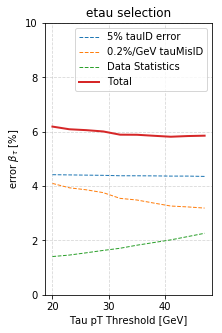

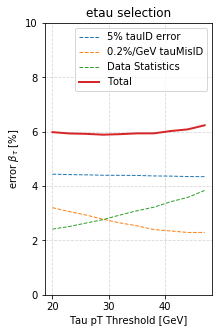

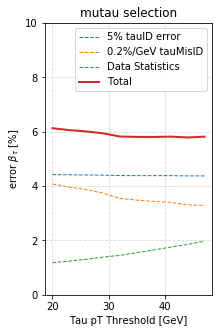

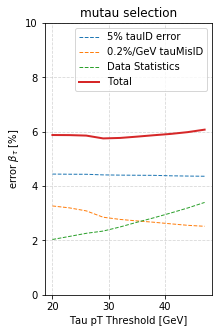

In [3]:
for dc in [DFCounter('e','1b'),DFCounter('e','2b'),DFCounter('mu','1b'),DFCounter('mu','2b')]:
    dc.setVariation('pta30')
    ondata = np.array( [ dc.getNData(slt,dc.nbjet)[0] for slt in dc.selections ] )
    onmcbg = np.array( [ dc.getNMCbg(slt,dc.nbjet)[0] for slt in dc.selections ] )
    onfake = np.array( [ dc.getNFake(slt,dc.nbjet)[0] for slt in dc.selections ] )
    oa     = np.array( [ dc.getAcc  (slt,dc.nbjet)[0] for slt in dc.selections ] )

    ndata,nmcbg,nfake,a = ondata.copy(), onmcbg.copy(), onfake.copy(), oa.copy()
    errID, errMisID, errStat = [],[],[]

    thrds = np.arange(20,50,3)
    for thrd in thrds:
        dc.setVariation('ptb{}'.format(int(thrd)))
        ndata[2] = dc.getNData('{}tau'.format(dc.trigger),dc.nbjet)[0]
        nmcbg[2] = dc.getNMCbg('{}tau'.format(dc.trigger),dc.nbjet)[0]
        a[2,:,:] = dc.getAcc('{}tau'.format(dc.trigger),dc.nbjet)[0]

        errID.append( getTauIDError(a,ndata,nmcbg,nfake,dc.trigger)[2] )
        errMisID.append( getTauMisIDError(a,ndata,nmcbg,nfake,dc.trigger,dc.nbjet)[2] )
        errStat.append( getStatError(a,ndata,nmcbg,nfake)[2] )


    err = np.abs(np.array([errID,errMisID,errStat]))

    plt.figure(facecolor='w',figsize=(3,5))
    plt.plot(thrds, err[0],lw=1,linestyle='--', label='5% tauID error')
    plt.plot(thrds, err[1],lw=1,linestyle='--',label='0.2%/GeV tauMisID')
    plt.plot(thrds, err[2],lw=1,linestyle='--',label='Data Statistics')
    plt.plot(thrds, np.sum(err**2,axis=0)**0.5, lw=2,label='Total')

    plt.xlabel('Tau pT Threshold [GeV]')
    plt.ylabel(r"error $\beta_\tau $ [%]")

    plt.legend()
    plt.grid(True,linestyle='--',alpha=0.5)
    plt.title(dc.trigger+'tau selection')
    plt.ylim(0,10)

    plt.savefig("../plots/scan_{}{}.png".format(dc.trigger,dc.usetag),dpi=300)

# 2. Optimze MCsg Statistical Error by including lep, semilep ttbar

In [3]:
counts = pd.read_pickle("/Users/zihengchen/Documents/Analysis/workplace/data/count/count_.pkl")

In [3]:
slt = []
for i in range(4):
    slv = BFSolver3D(counts.acc[i])
    obsX = slv.setMeasuredX(counts.ndata[i],counts.nmcbg[i]+counts.nfake[i])
    slt.append(slv.solveQuadEqn(obsX))
slt = np.array(slt)
slt

array([[0.10906   , 0.11190817, 0.11046231],
       [0.11311639, 0.11377278, 0.10780647],
       [0.10557132, 0.10544763, 0.10428385],
       [0.10835108, 0.10847748, 0.10495039]])

In [43]:
# solver 1D; error from BWe and BWm
errm = []
erre = []
for i in range(4):
    slv = BFSolver1D(counts.acc[i])
    slve = BFSolver1D(counts.acc[i],bWe=0.1071-0.0016, bWm=0.1063)
    slvm = BFSolver1D(counts.acc[i],bWe=0.1071, bWm=0.1063-0.0015)
    obsX = slv.setMeasuredX(counts.ndata[i],counts.nmcbg[i]+counts.nfake[i])
    
    errm.append(slvm.solveQuadEqn(obsX) - slv.solveQuadEqn(obsX))
    erre.append(slve.solveQuadEqn(obsX) - slv.solveQuadEqn(obsX))
errm = np.array(errm).reshape(-1)[np.array([1,2,4,5,6,8,9,11])]/0.1086 * 100
erre = np.array(erre).reshape(-1)[np.array([1,2,4,5,6,8,9,11])]/0.1086 * 100


In [58]:
# solver 1D: error from e,mu,tau eff
err = []
effUp = np.array([0,0,0.05,0]) + 1
for i in range(4):
    slv = BFSolver1D(counts.acc[i])
    slv1 = BFSolver1D(counts.acc[i] * effUp[:,None,None])
    
    BW = slv .solveQuadEqn(slv .setMeasuredX(counts.ndata[i],counts.nmcbg[i]+counts.nfake[i]))
    BW1= slv1.solveQuadEqn(slv1.setMeasuredX(counts.ndata[i],counts.nmcbg[i]* effUp+counts.nfake[i]))


    
    err.append(BW1-BW)
err = np.array(err).reshape(-1)[np.array([1,2,4,5,6,8,9,11])]/0.1086 * 100

In [60]:
print(list(abs(err)))

[0.4196690492852734, 0.1044862536329217, 0.4002783550551415, 0.0869299614802864, 7.7861199516056185, 0.0913757511240937, 7.482788365788479, 0.0732900164289858]


In [12]:
err = []        
for i in range(4):
    slv = BFSolver1D(counts.acc[i])
    BW  = slv.solveQuadEqn(slv.setMeasuredX(counts.ndata[i],counts.nmcbg[i]+counts.nfake[i]))

    # taking derivertive dBW/dnData
    deltaNData = np.identity(4)
    dBW_over_dnData = []
    for iDeltaNData in range(4):
        BW1 = slv.solveQuadEqn(slv.setMeasuredX( counts.ndata[i]+deltaNData[iDeltaNData],
                                                 counts.nmcbg[i]+counts.nfake[i]))
        dBW_over_dnData.append(BW1-BW)
    dBW_over_dnData = np.array(dBW_over_dnData)
    # propagating error
    errFromSource = np.matmul(counts.ndataVar[i], dBW_over_dnData**2)**0.5
    err.append(errFromSource)
err = np.array(err).reshape(-1)[np.array([1,2,4,5,6,8,9,11])]/0.1086 * 100

In [14]:
print(list(abs(err)))

[2.4917381068282967, 1.2158241216449708, 4.320565446921318, 2.0172081169243605, 4.861123962410149, 1.4037731328891698, 8.573592506996826, 2.4006219993556894]
